In [1]:
library(ggplot2)
library(dplyr)
library(reshape2)
library(binom)
library(tidyverse)
library(ggbreak)
library(ggVennDiagram)
library(ggvenn)
library(patchwork)
library(scales)
library(data.table)
library(ggpubr)
library(arrow)
library(readxl)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846


Loading requir

In [2]:
pl_theme = theme(plot.title = element_text(size = 20, face = "bold"), 
          axis.text=element_text(size=18),
          axis.title=element_text(size=20),
          legend.text = element_text(size=18),
          legend.title = element_text(size=20),
          strip.text = element_text(size=18)
         )
simple_annot_names = c('non-genic', 'putative regulatory', 'coding')

In [3]:
annot_colors <- c(
    "LoF" = "#DE3F2E",
    "missense" = "#FDD384",
    "synonymous" = "#E5E5AB",
    "UTR3" = "#807DBA",
    "UTR5" = "#BCBDDC",
    "promoter" = "#08519C",
    "CRE" = "#4292C6",
    "conserved" = "grey",
    "non-genic" = "#C6DBEF"
)
simple_annot_colors <- c(
    "coding" = "#FDD384",
    "putative regulatory" = "#08519C",
    "non-genic" = "#C6DBEF"
)
method_colors <- c(
    "SuSiE" = "#4169e1",
    "SuSiE-inf" = "#91dce3",
    "FINEMAP" = "#FFA500",
    "FINEMAP-inf" = "#673147",
    "ABF" = "#32CD32",
    "COJO-ABF" = "#cb98fb",
    "minPIP" = "#708090",
    "minPIP-inf" = "#ffb6c1")

pheno_colors <- c(
    "LDLC" = '#083647',
    "ALP" = '#5E4FA2',
    "HbA1c" = '#3F96B7',
    "Lym" = '#88CFA4',
    "Plt" = '#D7EF9B',
    "RBC" = 'yellow',
    "eGFR" = '#FDD380',
    "IGF1" = '#F88D51',
    "eBMD" = '#DC494C',
    "Height" = '#9E0142'
)
method_shapes <- c(
    "SuSiE" = 8,
    "SuSiE-inf" = 19,
    "FINEMAP" = 7,
    "FINEMAP-inf" = 15,
    "minPIP" = 9,
    "minPIP-inf" = 17
)

sim_colors <- c(
    "Ideal" = "#a0ddff",
    "Baseline misspecification" = "#758ecd",
    "Moderate stratification w/ BOLT" = "#ec9192",
    "Moderate non-sparsity" = "#729ea1",
    "High non-sparsity" = "#b5bd89",
    "Very high non-sparsity" = "#dfbe99",
    "No large effects" = "#ebbb5c",
    "Severe stratification w/ BOLT"="#8CBFAF",
    "Moderate stratification w/ OLS"="#023778",
    "Severe stratification w/ OLS"="#4281A4",
    "1% coverage, ratio=3:1"= "#b5bd89",
    "0.5% coverage, ratio=3:1"='#4FC47E',
    "5% coverage, ratio=3:1"='#D05B5B',
    "5% coverage, ratio=15:1"='#F2CD5D'
)

In [20]:
path_pref = ''

# Supplementary Fig. 1 -- RFR and functional enrichment for 4 methods

In [5]:
rfr_df = read_excel("Supplementary Tables.xlsx", sheet = 4)
all_rfr = rfr_df %>% dplyr::select('trait','method_name','n_highpip','rfr','epn','data.type')
all_rfr$segment_legend='EPN'
# Compute Binomial proportion SD
all_rfr$std = sqrt((all_rfr$rfr)*(all_rfr$n_highpip)*(1-all_rfr$rfr))/all_rfr$n_highpip
# Filter to aggregated RFR
selected_method_names = c('SuSiE','FINEMAP','COJO-ABF','ABF')
all_rfr[all_rfr=='Simulation'] = 'Ideal simulation'
data_to_plot = all_rfr %>% filter(trait=='agg') %>% filter(method_name %in% selected_method_names)
data_to_plot$method_name <- factor(data_to_plot$method_name, levels = selected_method_names)
data_to_plot$data.type <- factor(data_to_plot$data.type, levels=c('Real data','Ideal simulation'))
# Compute EPN line segment positions
num_methods = length(selected_method_names)
barwidth = 0.85/num_methods
pos_dodge = 1
xstart = c(seq(1-barwidth*num_methods/2,1+barwidth*num_methods/2-barwidth,length.out=num_methods),
  seq(1-barwidth*num_methods/2+pos_dodge, 1+barwidth*num_methods/2-barwidth+pos_dodge, length.out=num_methods))
xend = c(seq(1-barwidth*num_methods/2+barwidth,1+barwidth*num_methods/2,length.out=num_methods),
  seq(1-barwidth*num_methods/2+barwidth+pos_dodge,1+barwidth*num_methods/2+pos_dodge,length.out=num_methods))
# Plot
pl_rfr = ggplot(data=data_to_plot, aes(x=data.type, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=1,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1.5))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(axis.title.x = element_blank(),
                     legend.title = element_blank(),
                     axis.text.x = element_text(angle = 15, vjust = 0.5, hjust=0.5))

New names:
• `` -> `...1`
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [6]:
func_enrich = read_excel("Supplementary Tables.xlsx", sheet = 5)
selected_methods = c('SuSiE','FINEMAP','COJO-ABF','ABF')
selected_groups = c('Non-replicating','Replicated',"Matched on PIP at 100K",
                    "Matched on PIP at 366K", 'Background')
pl_list = list()
for (m in selected_methods){
    # collapse categories
    func_enrich_selected = (func_enrich %>% filter(method_name==m)
                            %>% filter(type %in% selected_groups)
                            %>% mutate(coding=(LoF + missense))
                            %>% mutate("putative regulatory"=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(type, coding, "putative regulatory", "non-genic"))
    # aggregate methods
    agg_methods <- func_enrich_selected %>% group_by(type) %>% summarise(across(all_of(simple_annot_names), sum))
    data <- as.data.frame(agg_methods)
    melted_data <-  reshape2::melt(data , id.vars = c("type"), measure.vars = simple_annot_names)
    data <- group_by(melted_data,type)
    data <- mutate(data, prop = value / sum(value), 
                   std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
                   sd_pos = cumsum(prop))
    data$type<-factor(data$type, levels= selected_groups)
    data$variable <- factor(data$variable,levels=simple_annot_names)
    # plot
    pl_list[[m]] <- qplot(x = type, y = prop, fill = variable, data = data, geom = "col") +
        geom_errorbar(aes(x=type,ymin=1-prop+std,ymax=1-prop-std),width=.1, 
                  data=data %>% filter(variable=='non-genic'),
                  inherit.aes = FALSE)+
        ggtitle(m) +
        scale_fill_manual(values = simple_annot_colors) +
        scale_y_continuous(label=c(0,0.25,0.5,0.75,1)) +
        pl_theme + theme(plot.title = element_text(hjust=0.4),
                         axis.title.y=element_blank(),
                         axis.title.x=element_blank(),
                         legend.title=element_blank()) + coord_flip()
}

New names:
• `` -> `...1`
Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


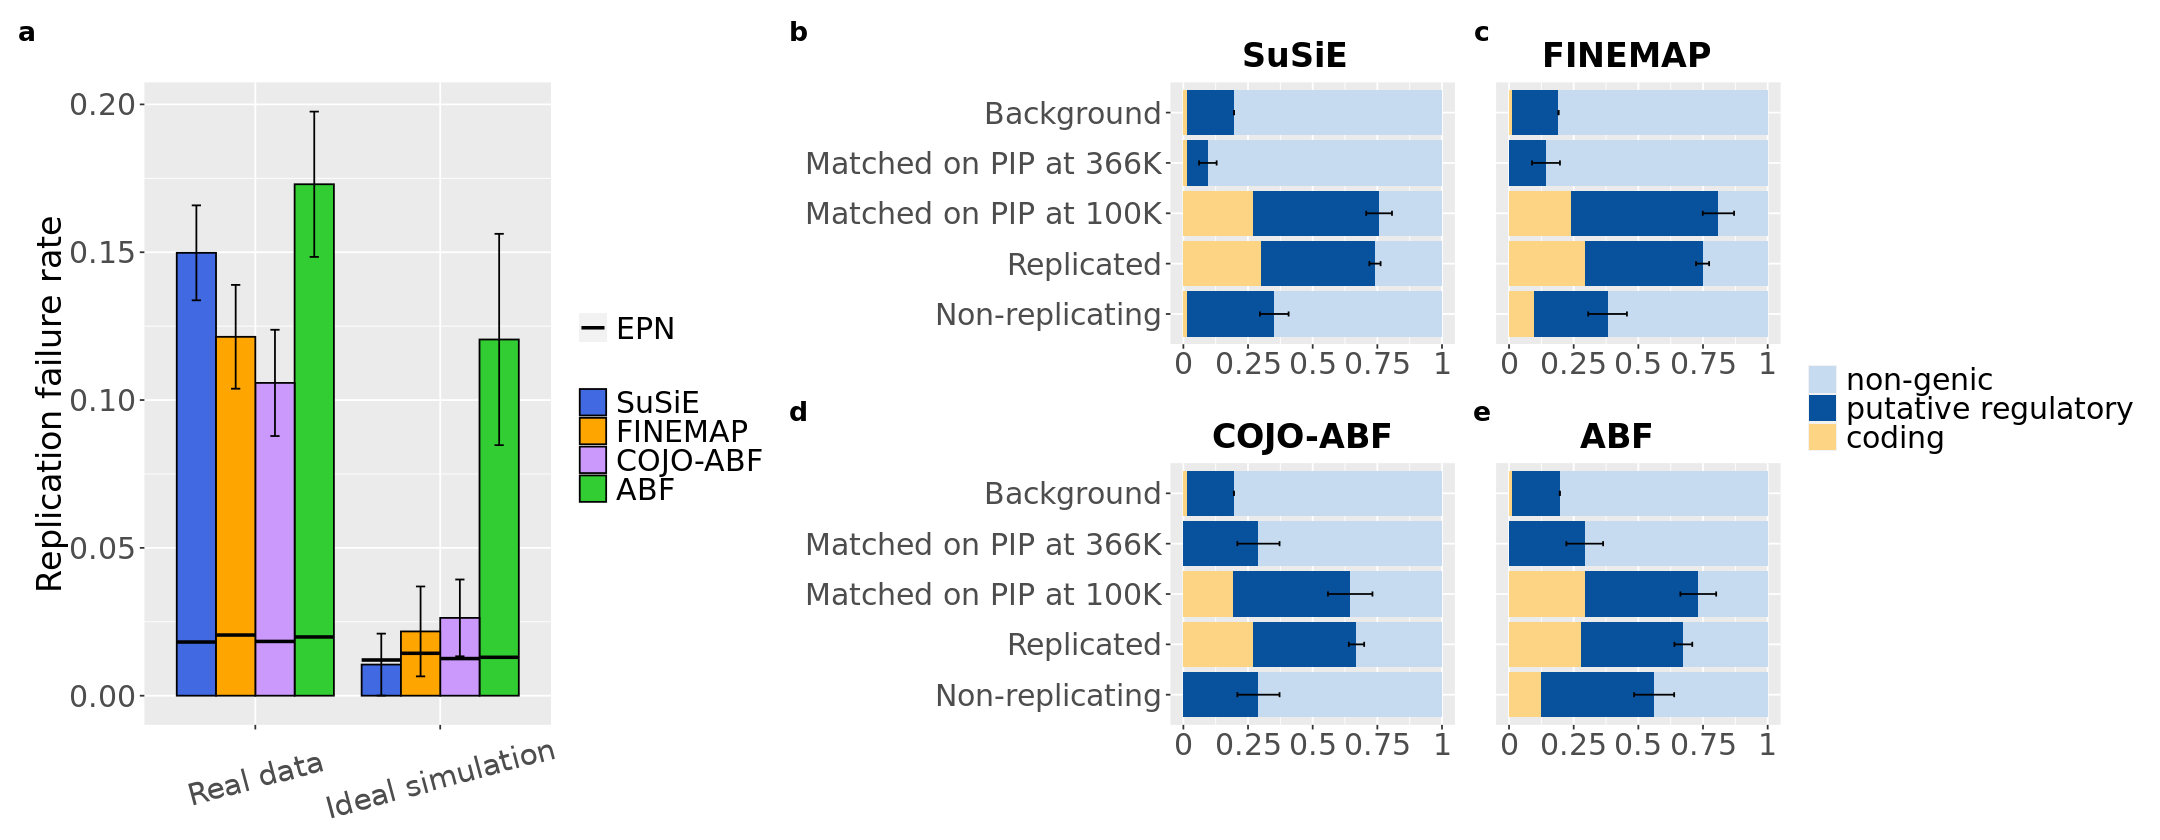

In [7]:
options(repr.plot.width=18, repr.plot.height=7)
pl_list[[2]] = pl_list[[2]] + theme(axis.text.y = element_blank(),
                         axis.ticks.y = element_blank(),
                         axis.title.y = element_blank())
pl_list[[4]] = pl_list[[4]] + theme(axis.text.y = element_blank(),
                         axis.ticks.y = element_blank(),
                         axis.title.y = element_blank())
pl_enrich_sep = pl_list[[1]] + pl_list[[2]] +  pl_list[[3]] + pl_list[[4]] + plot_layout(ncol=2,guides = "collect")

layout <- "
AABBB
"
supp_fig1 <- pl_rfr + pl_enrich_sep + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig1

# Supplementary Fig. 2 -- ABF and COJO calibration and recall

In [8]:
# Calibration
calib = read_excel("Supplementary Tables.xlsx", sheet = 29)
selected_method_names = c('SuSiE','FINEMAP','ABF','COJO-ABF')
calib[,c('mean','lower','upper')] = binom.confint(calib$num_causal,calib$num_snps, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
calib$bin <- factor(calib$bin, levels=c('[0,0.01]','(0.01,0.1]','(0.1,0.5]','(0.5,0.9]','(0.9,1]'))

pl_calib <- ggplot(calib %>% filter(method_name %in% selected_method_names) , aes(bin, prop_causal)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = method_name),
        position = position_dodge(1),
        size=1)+
    geom_point(aes(bin, mean_pip, group=method_name), position=position_dodge(1),
               color="Black", size=6, stroke=3, shape=95) +
    ggtitle('Calibration in ideal simulations')+
    ylab('Proportion causal')+
    xlab("PIP bins") + pl_theme + theme(legend.title=element_blank())+
    scale_color_manual(values=method_colors[selected_method_names])

New names:
• `` -> `...1`


In [9]:
# Recall
recall_df = read_excel("Supplementary Tables.xlsx", sheet = 30)
recall_df[,c('mean','lower','upper')] = binom.confint(recall_df$n_causal,recall_df$tot_causal, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
recall_df = recall_df %>% mutate(x = ifelse(top_perc==0.01,"0.01",
                                          ifelse(top_perc==0.05,"0.05",
                                                 ifelse(top_perc==0.1,"0.1",
                                                        ifelse(top_perc==0.5,"0.5",
                                                               ifelse(top_perc==1,"1",0))))))
selected_names = c('ABF','COJO-ABF','SuSiE','FINEMAP')
pl_recall <- ggplot(recall_df %>% filter(method_name %in% selected_names), aes(x, mean)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = method_name),
        position = position_dodge(0.3), size=1)+ 
    scale_color_manual(values=method_colors[selected_method_names])+
    ylab('Recall')+
    xlab("Top percentage of variants") + pl_theme + theme(legend.title=element_blank())
# Number of causal in false positive regions
num_snps_df = read.table(paste0(path_pref,'cojo_false_pos_regions.tsv'),
                         sep='\t', header=TRUE)
num_snps_df[num_snps_df=='Regions contain false positive SNPs'] = 'False positive regions'
pl_false_pos <- ggplot(num_snps_df, aes(x=causal, fill=type)) + 
 geom_histogram(aes(y=..density..), alpha=0.4, position="identity",binwidth=1)+
 xlab('Number of causal variants in region') +
 ylab('Density')+
scale_x_continuous(breaks= pretty_breaks()) + pl_theme + theme(legend.title=element_blank())

New names:
• `` -> `...1`


Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


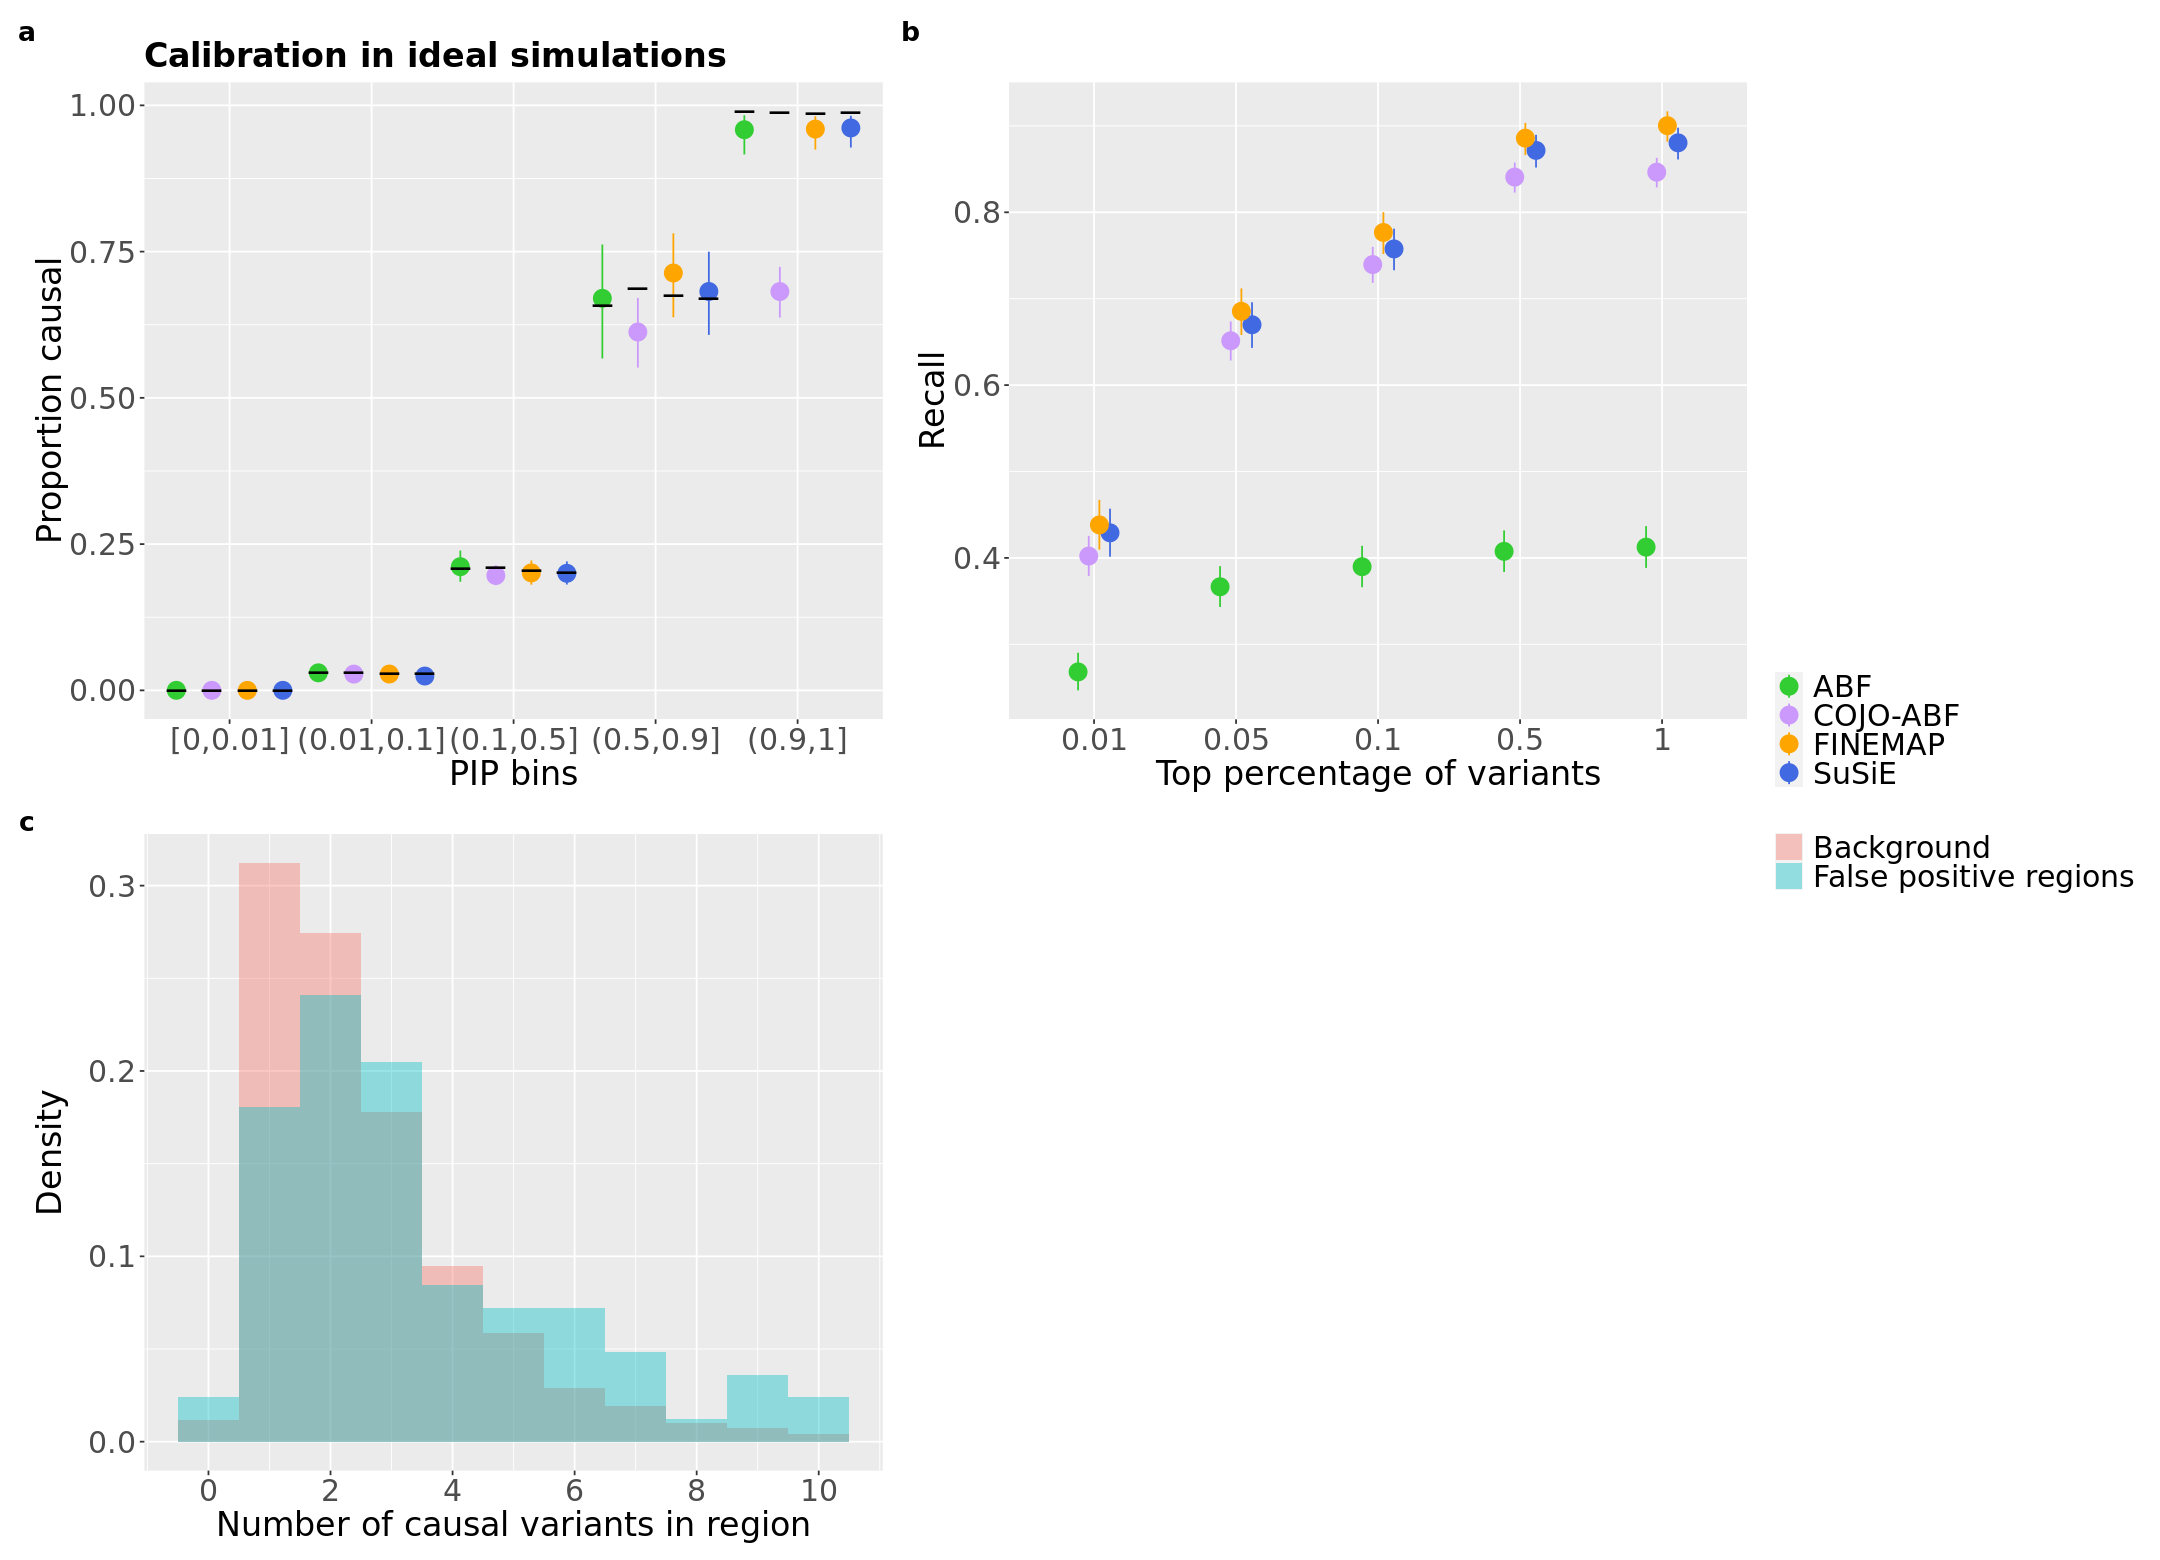

In [10]:
options(repr.plot.width=18, repr.plot.height=13)
calib_recall = pl_calib + pl_recall + plot_layout(ncol=2, guides="collect")

layout <- "
AB
C#
"
supp_fig2 <- calib_recall + pl_false_pos + plot_layout(design=layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig2

# Supplementary Data Fig. 3 -- Height chi-sq at different sample sizes

In [11]:
# this data is available on Zenodo
ht_bolt_ols_366k_to_plot = read_feather(paste0(path_pref,'ht_bolt_ols_366k_to_plot.feather'))
ht_bolt_ols_100k_to_plot = read_feather(paste0(path_pref,'ht_bolt_ols_100k_to_plot.feather'))
ht_bolt_280k_ols_366k_to_plot = read_feather(paste0(path_pref,'ht_bolt_280k_ols_366k_to_plot.feather'))
ht_bolt_88k_ols_100k_to_plot = read_feather(paste0(path_pref,'ht_bolt_88k_ols_100k_to_plot.feather'))

In [12]:
chisq_selected_points <- function(df, keep_quantile,n_sample){
    q = quantile(df$CHISQ_BOLT_LMM_INF, keep_quantile)
    to_keep <- df %>% filter(CHISQ_BOLT_LMM_INF>q)
    to_sample <- df %>% filter(CHISQ_BOLT_LMM_INF<q)
    smaller_sample <- to_sample[sample(nrow(to_sample), n_sample), ]
    return(rbind(to_keep,smaller_sample))
}

In [13]:
n_sample = 3000
ht_bolt_ols_366k_to_plot_smaller = chisq_selected_points(ht_bolt_ols_366k_to_plot, 0.9, n_sample)
ht_bolt_ols_100k_to_plot_smaller = chisq_selected_points(ht_bolt_ols_100k_to_plot, 0.9, n_sample)
ht_bolt_280k_ols_366k_to_plot_smaller = chisq_selected_points(ht_bolt_280k_ols_366k_to_plot, 0.9, n_sample)
ht_bolt_88k_ols_100k_to_plot_smaller = chisq_selected_points(ht_bolt_88k_ols_100k_to_plot, 0.9, n_sample)

In [14]:
pl_366k <- ggscatter(ht_bolt_ols_366k_to_plot_smaller, y = "CHISQ_BOLT_LMM_INF", x = "chisq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          ylab = "BOLT marginal chi-squared statistics", 
          xlab = "OLS marginal chi-squared statistics",
          title = "N=366K") + pl_theme + 
          scale_x_continuous(breaks = c(0,500, 1000), labels = c('0','500','1000'))
pl_100k <- ggscatter(ht_bolt_ols_100k_to_plot_smaller, y = "CHISQ_BOLT_LMM_INF", x = "chisq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          ylab = "BOLT marginal chi-squared statistics", 
          xlab = "OLS marginal chi-squared statistics",
          title = "N=100K") + pl_theme + 
          scale_x_continuous(breaks= pretty_breaks())
pl_280k <- ggscatter(ht_bolt_280k_ols_366k_to_plot_smaller, y = "CHISQ_BOLT_LMM_INF", x = "chisq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          ylab = "BOLT marginal chi-squared statistics at N=280K", 
          xlab = "OLS marginal chi-squared statistics at N=366K") + 
          pl_theme + scale_x_continuous(breaks = c(0,500, 1000), labels = c('0','500','1000'))
pl_88k <- ggscatter(ht_bolt_88k_ols_100k_to_plot_smaller, y = "CHISQ_BOLT_LMM_INF", x = "chisq", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson", cor.coef.size = 10,
          ylab = "BOLT marginal chi-squared statistics at N=88K", 
          xlab = "OLS marginal chi-squared statistics at N=100K") + 
          pl_theme

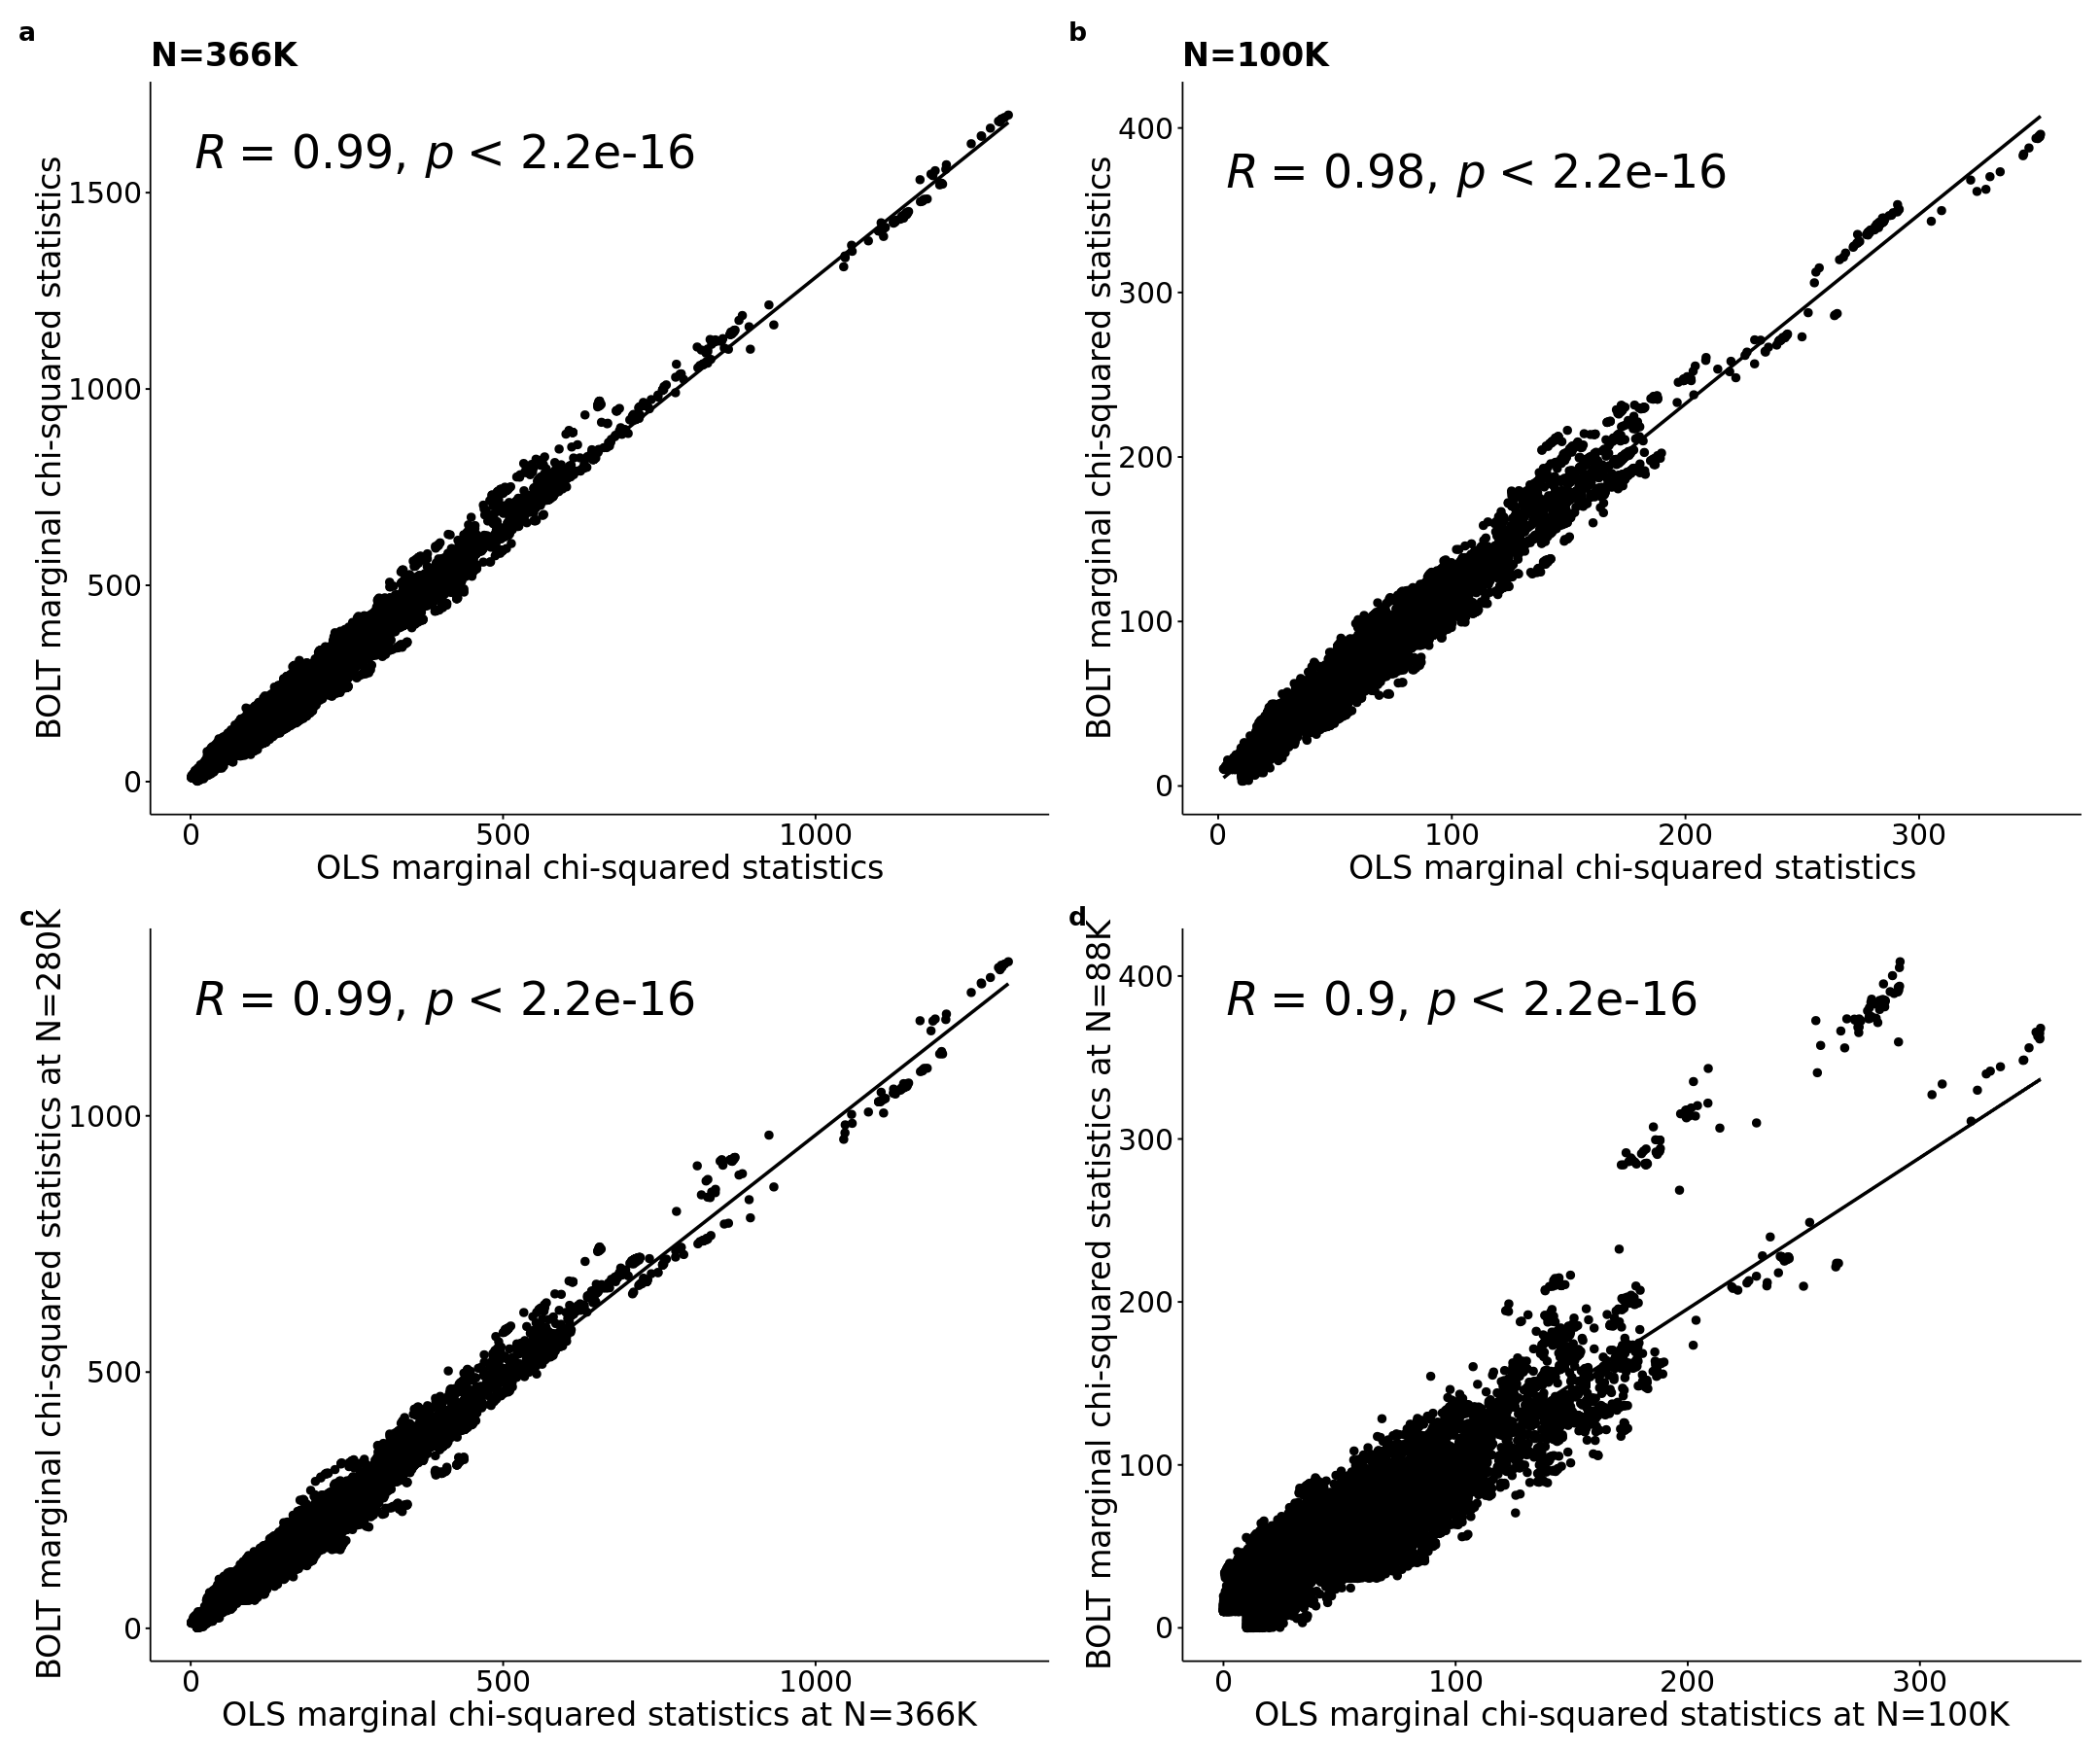

In [58]:
options(repr.plot.width=18, repr.plot.height=15)
layout <- "
AB
CD
"
supp_fig3 <- pl_366k + pl_100k + pl_280k + pl_88k +
 plot_layout(design=layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))

supp_fig3

# Supplementary Data Fig. 4 -- PolyFun RFR

New names:
• `` -> `...1`


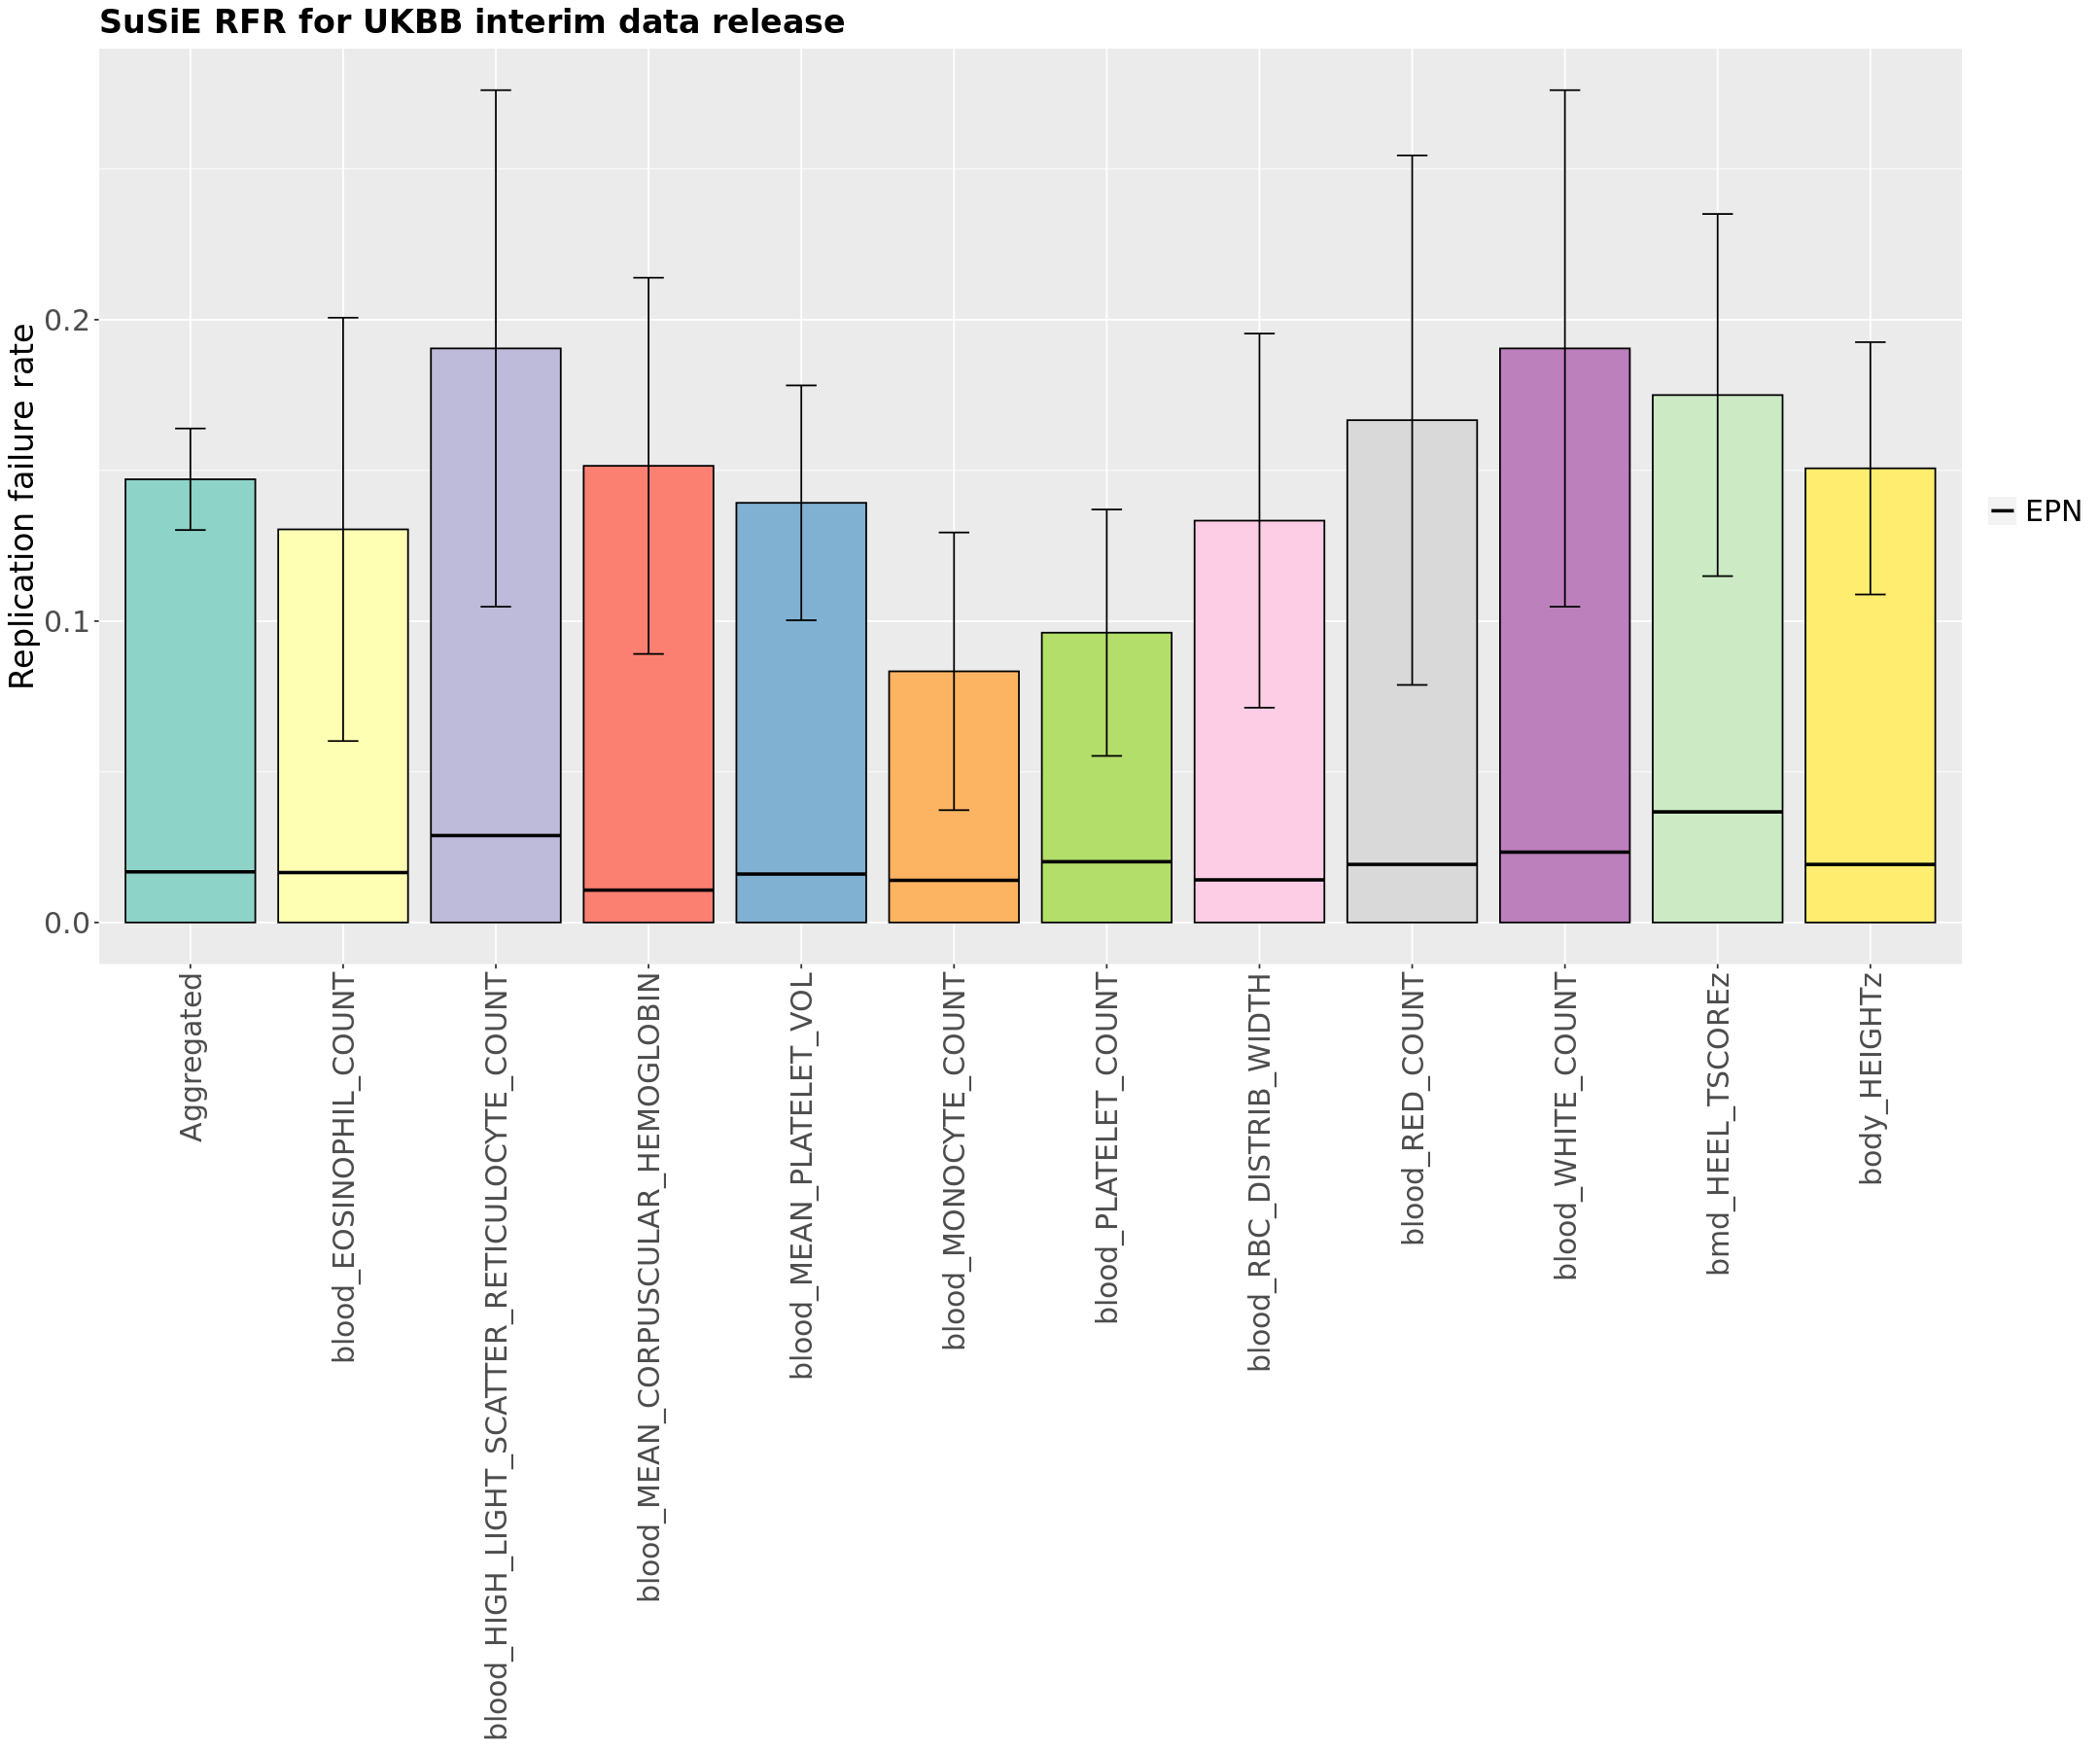

In [15]:
# Aggregated RFR plot
rfr_df = read_excel("Supplementary Tables.xlsx", sheet = 32)
all_rfr = rfr_df %>% dplyr::select('trait','n_highpip','n_nonrep','epn') %>% filter(n_highpip>15)
all_rfr[,c('mean','lower','upper')] = binom.confint(all_rfr$n_nonrep, all_rfr$n_highpip, 
                                                   conf.level=0.90, methods='exact')[,c('mean','lower','upper')]
all_rfr$segment_legend='EPN'
all_rfr$std = sqrt((all_rfr$mean)*(all_rfr$n_highpip)*(1-all_rfr$mean))/all_rfr$n_highpip

num_traits = length(unique(all_rfr$trait))
barwidth = 0.85 #0.85/num_traits
data_to_plot = all_rfr 

xstart = seq(1-barwidth/2,num_traits-barwidth/2,length.out=num_traits)
xend = seq(1-barwidth/2+barwidth,num_traits+barwidth/2,length.out=num_traits)

data_to_plot[data_to_plot=='agg'] = 'Aggregated'

pl_rfr = ggplot(data=data_to_plot, 
       aes(x=trait, y=mean, fill=trait)) +
    geom_bar(color='black', stat="identity",width=0.85, show.legend = FALSE) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=trait,linetype=`segment_legend`), 
                 size=1,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=mean-std, ymax=mean+std),position=position_dodge(.85),width=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1.5))+
    ggtitle('SuSiE RFR for UKBB interim data release') + scale_fill_brewer(palette="Set3") +
    pl_theme + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                     legend.title=element_blank(), axis.title.x = element_blank())
options(repr.plot.width=18, repr.plot.height=15)
pl_rfr

# Supplementary Data Fig. 5 -- further investigation into non-replication

In [16]:
df = read_excel("Supplementary Tables.xlsx", sheet = 33)

New names:
• `` -> `...1`


In [17]:
column_names = c('MAF','INFO','chisq_ds','LDscore','prob_diff','prob_ds','exp_causal_100kb')
type_names = c('MAF','INFO','Chi-square','LDscore','PIP diff', 'PIP at 100K','Expected #causal within 100kb')
flip_status = c(TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE)
make_rfr_df <- function(df,threshold_colname, type_name, flip){
    df_full_exist = df[!is.na(df$prob_full),]
    df_filtered = df_full_exist[!is.na(df_full_exist[threshold_colname]),]
    thresholds = quantile(df_filtered[,threshold_colname], probs=seq(0,1,0.1),na.rm=TRUE)
    rfr_df <- data.frame(matrix(ncol = 0, nrow = length(thresholds)))
    rfr_df$threshold = thresholds
    i = 1
    for (t in thresholds){
        if (flip){
            n_df = df_filtered[df_filtered[threshold_colname]<=t,]
        }
        else{
            n_df = df_filtered[df_filtered[threshold_colname]>=t,]
        }
        nonrep = n_df[n_df['prob_full']<=0.1,]
        rfr_df[i,'n_highpip'] = nrow(n_df)
        rfr_df[i,'n_nonrep'] = nrow(nonrep)
        rfr_df[i,'n_rep'] = nrow(n_df[n_df['prob_full']>=0.9,])
        i = i+1
    }
    rfr_df[,c('mean','lower','upper')] = binom.confint(rfr_df$n_nonrep,
                                                       rfr_df$n_highpip,
                                                       conf.level=0.95,
                                                       methods='exact')[,c('mean','lower','upper')]
    rfr_df$type = type_name
    return(rfr_df)
}
# SuSiE & FINEMAP aggregated
rfr_df_list = list()
for (i in 1:length(type_names)){
    rfr_df_list[[i]] = make_rfr_df(df,column_names[i],type_names[i],flip_status[i])
}
rfr_df_all = bind_rows(rfr_df_list)
rfr_df_all$type = factor(rfr_df_all$type, levels=type_names)
rfr_df_all = rfr_df_all %>% filter(n_rep>=50)
# plot
pl_snp_properties = ggplot(rfr_df_all, aes(x=n_rep, y=mean, group=type, color=type)) +
      geom_line(aes(color=type),linewidth=1.5)+
      geom_point(size=2.5)+
    scale_color_brewer(palette="Set3")+
    ylab('Replication failure rate')+xlab('Number of replicated SNPs')+
    ggtitle(sprintf('%s RFR v.s. #replications','SuSiE&FINEMAP agg'))+
    pl_theme + theme(legend.title=element_blank())

In [18]:
all_data = read_excel("Supplementary Tables.xlsx", sheet = 34)
pl_height10 <- ggplot(all_data, aes(x=factor(type),y=n))+
 geom_dotplot(binaxis='y',stackdir = "center",binwidth=0.5)+
 ylab('# downsampling analyses')+
 ggtitle('Number of appearances in 10 Height downsampling analyses for non-replicating and replicated regions')+
 pl_theme+theme(axis.title.x=element_blank())+
scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1)))))

New names:
• `` -> `...1`


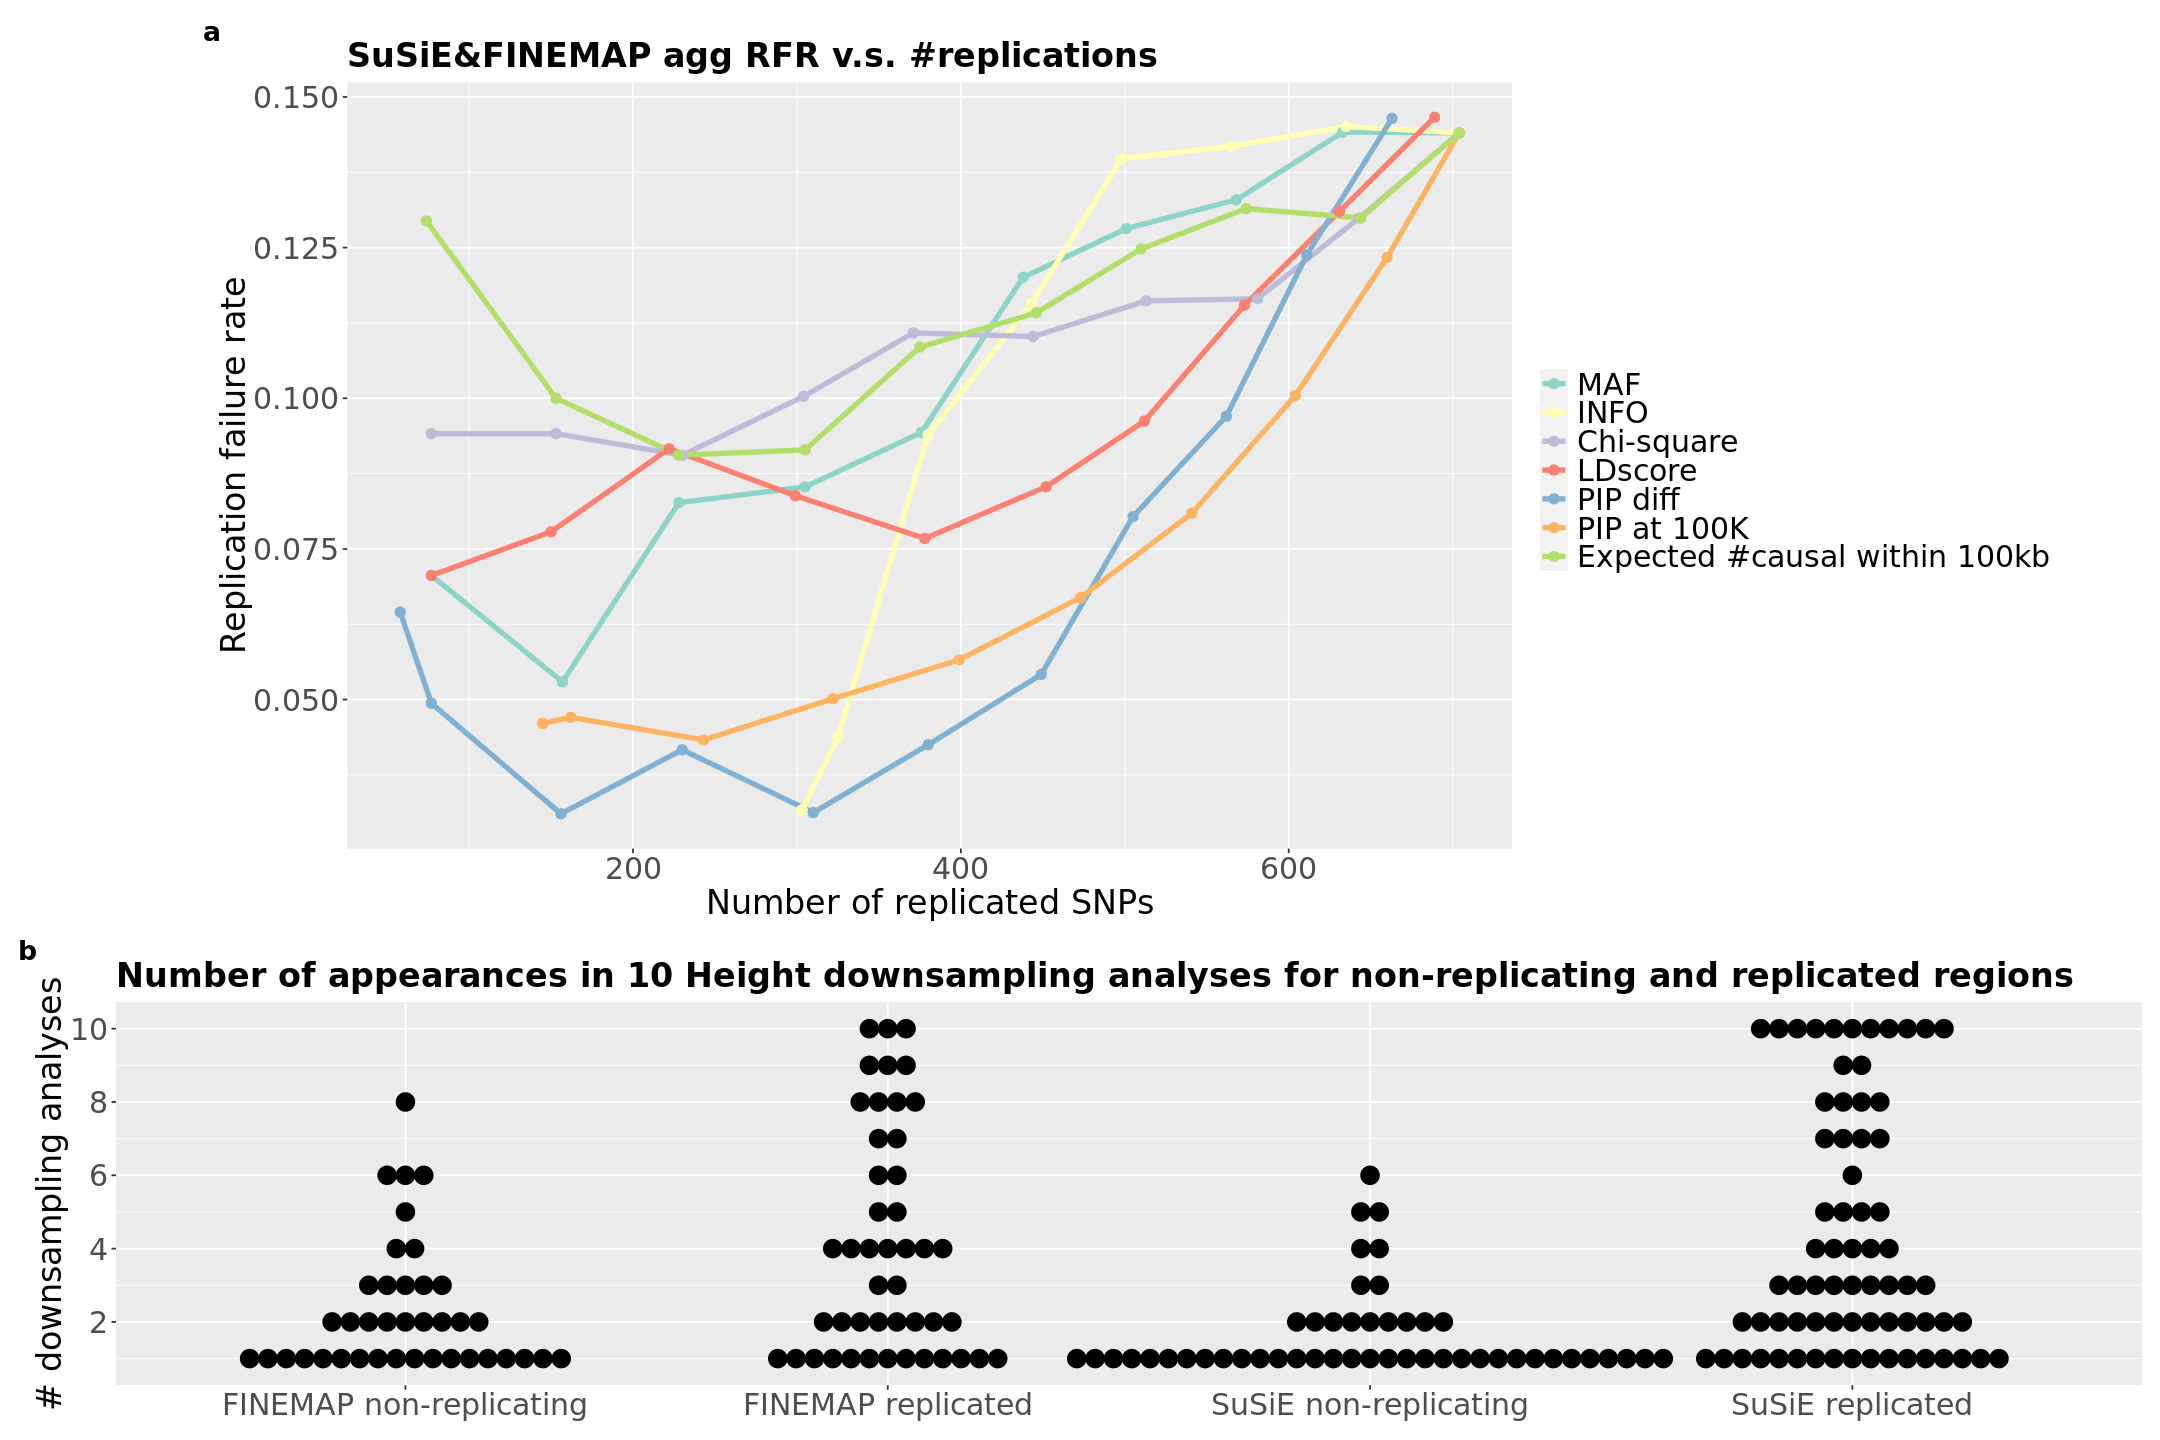

In [19]:
options(repr.plot.width=18, repr.plot.height=12)
layout <- "
#AAAAAAAAAAAAAAA#
#AAAAAAAAAAAAAAA#
BBBBBBBBBBBBBBBBB
"
supp_fig5 <- pl_snp_properties + pl_height10 + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=16))
supp_fig5